In [16]:
# === Imports ===
import os
import icd10
import pickle
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sksurv.metrics import concordance_index_censored

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# === Paths ===
PROJ_PATH = '/data/gusev/USERS/jpconnor/clinical_text_project/'
FIGURE_PATH = os.path.join(PROJ_PATH, 'figures/model_metrics/')
DATA_PATH = os.path.join(PROJ_PATH, 'data/')
SURV_PATH = os.path.join(DATA_PATH, 'survival_data/')
RESULTS_PATH = os.path.join(SURV_PATH, 'results/icd_results/')
FULL_COHORT_PATH = os.path.join(RESULTS_PATH, 'full_cohort/')
FEATURE_COMPS_PATH = os.path.join(RESULTS_PATH, 'feature_comps/')

events = list(set(os.listdir(FULL_COHORT_PATH)) & set(os.listdir(FEATURE_COMPS_PATH)))
features = ['stage', 'treatment', 'somatic', 'prs', 'text']

c_index_data = []; mean_auc_data = [];
for event in events:
    if icd10.exists(event):
        event_code = icd10.find(event)
        event_descr = event_code.description
        try:
            event_chapter = event_code.chapter
            event_block_descr = event_code.block_description
        except:
            event_chapter = None; event_block_descr = None;
    else:
        event_descr = None; event_chapter = None; event_block_descr = None;

    event_full_path = os.path.join(FULL_COHORT_PATH, event)
    event_feat_path = os.path.join(FEATURE_COMPS_PATH, event)

    full_text_metrics = pd.read_csv(os.path.join(event_full_path, 'text_test.csv'))
    full_base_metrics = pd.read_csv(os.path.join(event_full_path, 'type_model_metrics.csv'))
    full_base_test_metrics = full_base_metrics.loc[full_base_metrics['eval_data'] == 'test_data']
    
    full_base_c_index, full_base_mean_auc = full_base_test_metrics[['mean_c_index', 'mean_auc(t)']].values[0]
    full_text_c_index, full_text_mean_auc = full_text_metrics[['mean_c_index', 'mean_auc(t)']].values[0]

    feature_comp_metrics = [pd.read_csv(os.path.join(event_feat_path, f'{feature}_test.csv')) for feature in features]
    feature_c_indices = [df['mean_c_index'].values[0] for df in feature_comp_metrics]
    feature_mean_aucs = [df['mean_auc(t)'].values[0] for df in feature_comp_metrics]

    c_index_data.append([event, event_descr, event_chapter, event_block_descr, full_base_c_index, full_text_c_index] + feature_c_indices)
    mean_auc_data.append([event, event_descr, event_chapter, event_block_descr, full_base_mean_auc, full_text_mean_auc] + feature_mean_aucs)

base_columns = ['event', 'event_description', 'event_chapter', 'event_chapter_description']
complete_c_index_metric_df = pd.DataFrame(c_index_data, columns = base_columns + ['full_cohort_base_c_index', 'full_cohort_text_c_index'] + [f'{feature}_c_index' for feature in features])
complete_auc_metric_df = pd.DataFrame(mean_auc_data, columns = base_columns + ['full_cohort_base_mean_auc(t)', 'full_cohort_text_mean_auc(t)'] + [f'{feature}_mean_auc(t)' for feature in features])

complete_c_index_metric_df.to_csv(os.path.join(RESULTS_PATH, 'level_3_ICDs_c_index_df.csv'), index=False)
complete_auc_metric_df.to_csv(os.path.join(RESULTS_PATH, 'level_3_ICDs_mean_auc_df.csv'), index=False)

In [17]:
# complete_c_index_metric_df[['event', 'event_description', 'event_chapter', 'event_chapter_description']].to_csv(os.path.join(DATA_PATH, 'ICD_level_3_to_predict.csv'), index=False)
event_subset = pd.read_csv(os.path.join(DATA_PATH, 'oncology_relevant_ICD_level_3.csv'))

In [20]:
complete_c_index_metric_df['improvement_in_c_index_w_text'] = (complete_c_index_metric_df['full_cohort_text_c_index'] - complete_c_index_metric_df['full_cohort_base_c_index']).apply(lambda x : round(x, 3))

In [26]:
complete_c_index_metric_df.sort_values(by='improvement_in_c_index_w_text')['event'].iloc[0:10].tolist()

['J70', 'J44', 'J69', 'E07', 'N93', 'K58', 'J34', 'D62', 'A09', 'G93']

## Full Cohort Comparisons

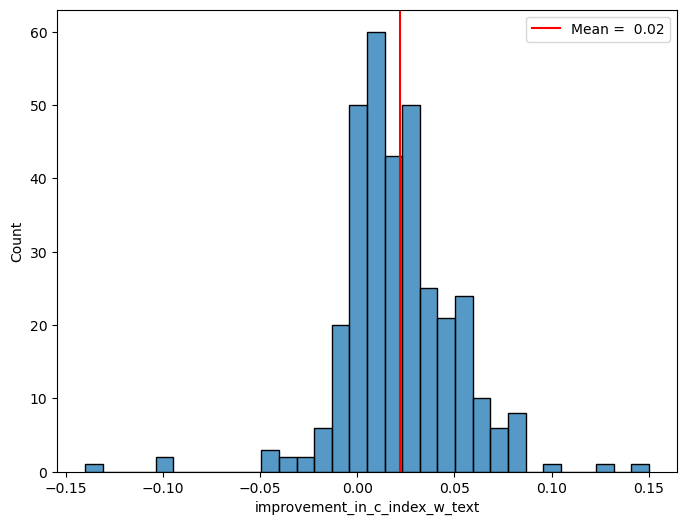

In [21]:
mean_improvement = complete_c_index_metric_df['improvement_in_c_index_w_text'].mean()
plt.figure(figsize=(8,6))
sns.histplot(complete_c_index_metric_df, x='improvement_in_c_index_w_text')
plt.axvline(x=mean_improvement, color='red', label=f'Mean = {mean_improvement : 0.2f}')
plt.legend()

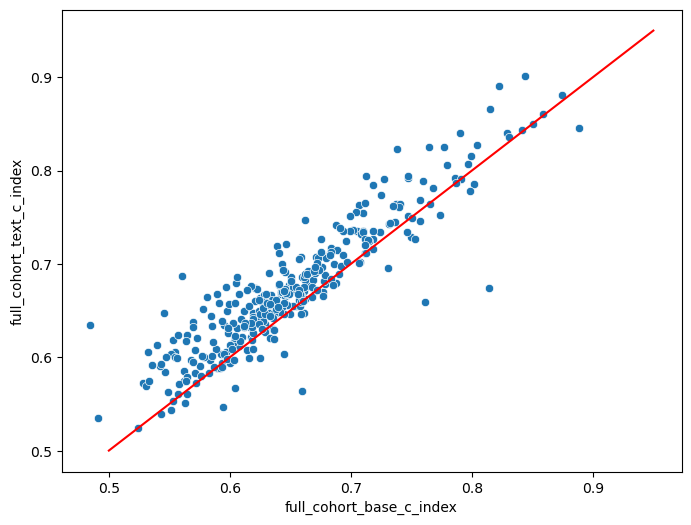

In [4]:
plt.figure(figsize=(8,6))
sns.scatterplot(complete_c_index_metric_df, x='full_cohort_base_c_index', y='full_cohort_text_c_index')
line_vals = np.linspace(0.5, 0.95, 100)
plt.plot(line_vals, line_vals, color='red')

In [5]:
complete_c_index_metric_df.sort_values(by='improvement_in_c_index_w_text', ascending=False).iloc[0:25][['event', 'event_description', 'improvement_in_c_index_w_text']]

,event,event_description,improvement_in_c_index_w_text
143,M76,"Enthesopathies, lower limb, excluding foot",0.150
125,M77,Other enthesopathies,0.126
293,L60,Nail disorders,0.101
71,liverM,None,0.085
26,L82,Seborrheic keratosis,0.085
17,L72,Follicular cysts of skin and subcutaneous tissue,0.083
195,nodeM,None,0.082
35,R69,"Illness, unspecified",0.081
139,B99,Other and unspecified infectious diseases,0.080
270,F33,"Major depressive disorder, recurrent",0.079


In [6]:
complete_c_index_metric_df.sort_values(by='improvement_in_c_index_w_text', ascending=True).iloc[0:25][['event', 'event_description', 'improvement_in_c_index_w_text']]

,event,event_description,improvement_in_c_index_w_text
93,J70,Respiratory conditions due to other external a...,-0.140
113,J44,Other chronic obstructive pulmonary disease,-0.102
330,J69,Pneumonitis due to solids and liquids,-0.096
238,E07,Other disorders of thyroid,-0.048
11,N93,Other abnormal uterine and vaginal bleeding,-0.042
317,K58,Irritable bowel syndrome,-0.041
19,J34,Other and unspecified disorders of nose and na...,-0.037
315,D62,Acute posthemorrhagic anemia,-0.036
184,A09,"Infectious gastroenteritis and colitis, unspec...",-0.026
284,G93,Other disorders of brain,-0.026


In [12]:
(complete_c_index_metric_df.loc[complete_c_index_metric_df['event_description'].isna(), ['event', 'full_cohort_text_c_index', 'full_cohort_base_c_index', 'improvement_in_c_index_w_text']]
    .sort_values(by='full_cohort_text_c_index', ascending=False).round(3))

,event,full_cohort_text_c_index,full_cohort_base_c_index
109,peritonealM,0.840,0.790
265,brainM,0.830,NaN
50,adrenalM,0.828,0.804
121,lungM,0.825,0.764
71,liverM,0.823,0.738
195,nodeM,0.794,0.713
0,boneM,0.785,0.718
164,death,0.721,0.647
291,vte,0.636,0.624


In [94]:
complete_c_index_metric_df['event_chapter_description'].unique()
event_chapter_dict = {'Symptoms, signs and abnormal clinical and laboratory findings, not elsewhere classified' : 'Misc. Findings',
                      'Certain infectious and parasitic diseases' : 'ID and Parasites',
                      'Diseases of the respiratory system' : 'Respiratory Diseases', None : None,
                      'Endocrine, nutritional and metabolic diseases' : 'Endocrine/Metabolic Diseases',
                      'Diseases of the digestive system' : 'GI Diseases',
                      'Diseases of the skin and subcutaneous tissue' : 'Skin Diseases',
                      'Diseases of the circulatory system' : 'Circulatory Diseases',
                      'Diseases of the musculoskeletal system and connective tissue' : 'Musculoskeletal Diseases',
                      'Diseases of the eye and adnexia' : 'Eye Diseases',
                      'Diseases of the genitourinary system' : 'GU Diseases',
                      'Diseases of the ear and mastoid process' : 'Ear Diseases',
                      'Diseases of the blood and blood-forming organs and certain disorders involving the immune mechanism' : 'Hematological/Immune Diseases',
                      'Mental and behavioural disorders' : 'Mental Disorders',
                      'Diseases of the nervous system' : 'Nervous System Diseases'}
complete_c_index_metric_df['event_chapter_descr_simple'] = complete_c_index_metric_df['event_chapter_description'].map(event_chapter_dict)

/tmp/ipykernel_403696/554659982.py:26: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: ttest_rel(


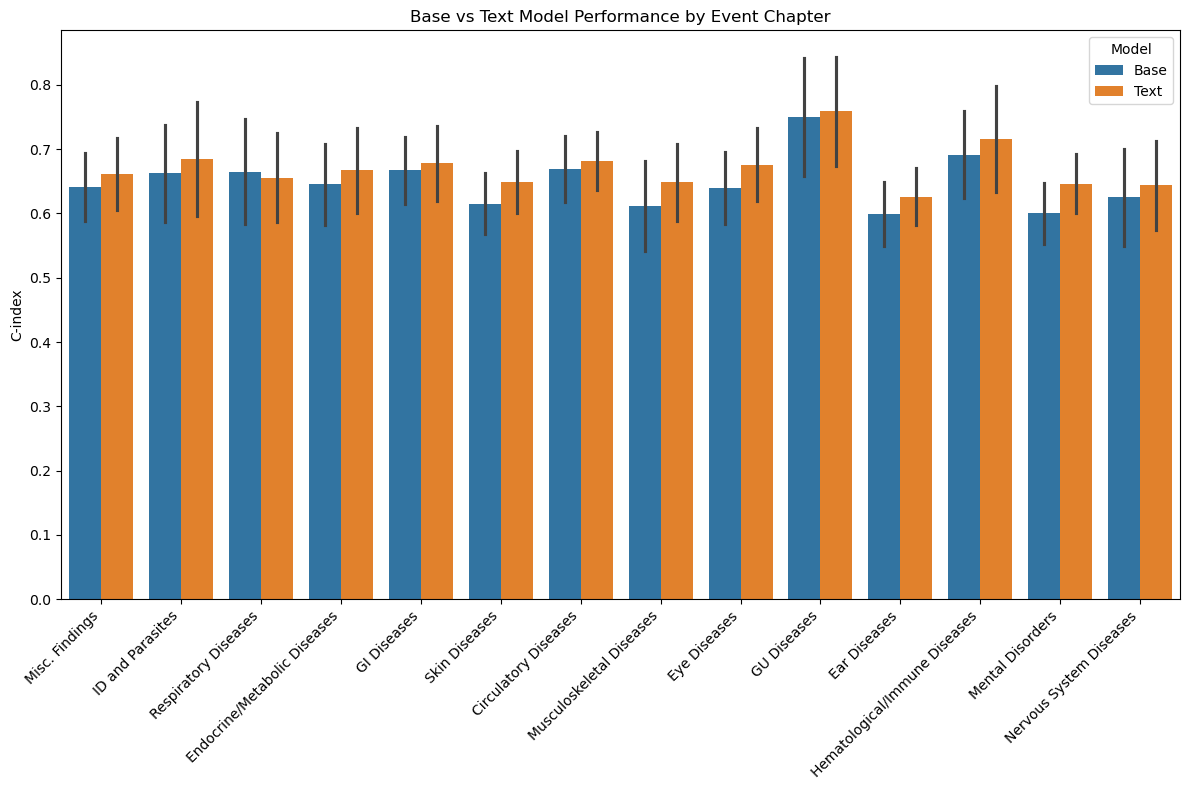

In [103]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel

# --- INPUT df columns expected ---
df = complete_c_index_metric_df.loc[complete_c_index_metric_df['event_chapter_descr_simple'].notna()].copy()

# ---------- 1) Long format for seaborn ----------
long = df.melt(
    id_vars=["event", "event_chapter_descr_simple"],
    value_vars=["full_cohort_base_c_index", "full_cohort_text_c_index"],
    var_name="model",
    value_name="c_index",
)

long["model"] = long["model"].map({
    "full_cohort_base_c_index": "Base",
    "full_cohort_text_c_index": "Text",
})

# ---------- 2) Paired significance tests per event chapter ----------
stats = (
    df.groupby("event_chapter_descr_simple", sort=False)
      .apply(lambda x: ttest_rel(
          x["full_cohort_text_c_index"],
          x["full_cohort_base_c_index"],
          nan_policy="omit"
      ).pvalue)
      .rename("pval")
      .reset_index()
)

def p_to_star(p: float) -> str:
    if pd.isna(p):
        return "na"
    if p < 0.001:
        return "***"
    if p < 0.01:
        return "**"
    if p < 0.05:
        return "*"
    return "ns"

stats["sig"] = stats["pval"].apply(p_to_star)

# Ensure annotation order matches x-axis order
order = df["event_chapter_descr_simple"].drop_duplicates().tolist()
stats["event_chapter_descr_simple"] = pd.Categorical(
    stats["event_chapter_descr_simple"], categories=order, ordered=True
)
stats = stats.sort_values("event_chapter_descr_simple").reset_index(drop=True)

# ---------- 3) Plot: grouped bars with SD error bars ----------
plt.figure(figsize=(12, 8))
ax = sns.barplot(
    data=long,
    x="event_chapter_descr_simple",
    y="c_index",
    hue="model",
    order=order,
    errorbar="sd",   # SD across rows (e.g., folds) within each (event, model)
)

ax.set_ylabel("C-index")
ax.set_xlabel("")
ax.set_title("Base vs Text Model Performance by Event Chapter")
plt.xticks(rotation=45, ha="right")
ax.legend(title="Model")
    
plt.tight_layout()
plt.show()

In [89]:
df_plot

,full_cohort_base_c_index_mean,full_cohort_base_c_index_std,full_cohort_text_c_index_mean,full_cohort_text_c_index_std,delta
event_chapter_description,,,,,
Diseases of the respiratory system,0.664985,0.081357,0.655801,0.069739,-0.009183
Diseases of the genitourinary system,0.750111,0.092042,0.758578,0.084053,0.008467
Diseases of the digestive system,0.666829,0.052053,0.678199,0.058265,0.011370
Diseases of the circulatory system,0.668628,0.051502,0.681453,0.044713,0.012824
Diseases of the nervous system,0.625395,0.075486,0.643795,0.069327,0.018400
"Symptoms, signs and abnormal clinical and laboratory findings, not elsewhere classified",0.641357,0.053243,0.661074,0.055502,0.019717
"Endocrine, nutritional and metabolic diseases",0.645596,0.063015,0.667065,0.065857,0.021469
Certain infectious and parasitic diseases,0.662381,0.075583,0.684997,0.089085,0.022616
Diseases of the blood and blood-forming organs and certain disorders involving the immune mechanism,0.691650,0.068214,0.715775,0.082878,0.024124


## Feature Comps

In [78]:
complete_c_index_metric_df

,event,event_description,event_chapter,event_chapter_description,full_cohort_base_c_index,full_cohort_text_c_index,stage_c_index,treatment_c_index,somatic_c_index,prs_c_index,text_c_index,full_cohort_deltas,improvement_in_c_index_w_text
0,R25,Abnormal involuntary movements,XVIII,"Symptoms, signs and abnormal clinical and labo...",0.586554,0.589292,0.501167,0.487352,0.492901,0.503119,0.460794,0.002738,0.003
1,R49,Voice and resonance disorders,XVIII,"Symptoms, signs and abnormal clinical and labo...",0.634729,0.661788,0.711076,0.734823,0.720487,0.710706,0.720302,0.027059,0.027
2,A49,Bacterial infection of unspecified site,I,Certain infectious and parasitic diseases,0.564847,0.560094,0.476810,0.461267,0.475355,0.475355,0.427811,-0.004752,-0.005
3,J84,Other interstitial pulmonary diseases,X,Diseases of the respiratory system,0.642518,0.667342,0.670736,0.640983,0.609008,0.670736,0.652334,0.024825,0.025
4,nodeM,None,None,None,0.716793,0.791330,0.650042,0.614192,0.631031,0.599511,0.682569,0.074537,0.075
...,...,...,...,...,...,...,...,...,...,...,...,...,...
333,M67,Other disorders of synovium and tendon,XIII,Diseases of the musculoskeletal system and con...,0.551122,0.603023,0.412388,0.409497,0.339408,0.389872,0.409497,0.051901,0.052
334,I73,Other peripheral vascular diseases,IX,Diseases of the circulatory system,0.671300,0.694384,0.671298,0.672825,0.654104,0.671298,0.687358,0.023084,0.023
335,D70,Neutropenia,III,Diseases of the blood and blood-forming organs...,0.676785,0.708887,0.628077,0.648176,0.635882,0.627342,0.650805,0.032102,0.032
336,D59,Acquired hemolytic anemia,III,Diseases of the blood and blood-forming organs...,0.767973,0.780805,0.540624,0.601261,0.657194,0.642185,0.646788,0.012832,0.013
